In [12]:
import torch
import numpy as np
import glob
import os

from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import (
    AsDiscrete,
    Activations,
    Compose,
    LoadImaged,
    ConvertToMultiChannelBasedOnBratsClassesd,
    CropForegroundd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandShiftIntensityd,
    RandScaleIntensityd,
    Lambdad,
    EnsureChannelFirstd,
    ToTensord,
)
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss, DiceCELoss
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from functools import partial

from tqdm.notebook import tqdm

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
#dataset_list = []

# read all folders in Images

base_path = "Task01_BrainTumour/"

train_images = sorted(glob.glob(os.path.join(base_path, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(base_path, "labelsTr", "*.nii.gz")))

dataset_list = [
    {"img": image_name, "seg": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

"""
for file in os.listdir(os.path.join(base_path, "imagesTr")):

    data_dict = {
        "img": os.path.join(base_path, "imagesTr", file), 
        "seg": os.path.join(base_path, "labelsTr", file)
    }
    dataset_list.append(data_dict)"""

train_dataset_list, val_dataset_list = dataset_list[:-94], dataset_list[-94:]

# only use 70 percent of the total data
train_dataset_list, val_dataset_list = train_dataset_list[:int(len(train_dataset_list)*0.7)], val_dataset_list[:int(len(val_dataset_list)*0.7)]

print(len(train_dataset_list), len(val_dataset_list))

273 65


In [15]:
from monai.transforms import (
    Compose,
    LoadImage,
    ConvertToMultiChannelBasedOnBratsClasses,
    CropForeground,
    RandSpatialCrop,
    RandFlip,
    NormalizeIntensity,
    RandShiftIntensity,
    RandScaleIntensity,
    EnsureChannelFirst,
    Lambda
)


img = LoadImage(image_only=True)(train_dataset_list[0]["img"])
print(img.shape)

"""img = EnsureChannelFirst()(train_dataset_list[0])
print(img.shape)"""

img = EnsureChannelFirst()(img)
print(img.shape)

img = Lambda(lambda x: x.permute(3,2,0,1))(img)
print(img.shape)

img = CropForeground()(img)
print(img.shape)

img = RandSpatialCrop((128, 128, 128), random_size=False)(img)
print(img.shape)

img = RandFlip(prob=0.5, spatial_axis=0)(img)
print(img.shape)

img = NormalizeIntensity(nonzero=True, channel_wise=True)(img)
print(img.shape)

img = RandShiftIntensity(offsets=0.1, prob=1.0)(img)
print(img.shape)

img = RandScaleIntensity(prob=0.5, factors=0.1)(img)
print(img.shape)


torch.Size([240, 240, 155, 4])
torch.Size([4, 240, 240, 155])
torch.Size([155, 240, 4, 240])
torch.Size([155, 176, 4, 136])
torch.Size([155, 128, 4, 128])
torch.Size([155, 128, 4, 128])
torch.Size([155, 128, 4, 128])
torch.Size([155, 128, 4, 128])
torch.Size([155, 128, 4, 128])


In [16]:
"""train_transform = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            #ConvertToMultiChannelBasedOnBratsClassesd(keys="seg"),
            #Lambdad(keys=["img", "seg"], func=lambda x: x.permute(3,2,0,1)),
            EnsureChannelFirstd(keys=["img", "seg"]),
            Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0,3,1,2)),
            CropForegroundd(
                keys=["img", "seg"],
                source_key="img",
                #k_divisible=[128, 128, 128],
            ),
            RandSpatialCropd(
                keys=["img", "seg"],
                roi_size=[96, 96, 96],
                random_size=False,
            ),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=2),
            NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
            RandScaleIntensityd(keys="img", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="img", offsets=0.1, prob=1.0),
        ]
    )

val_transform = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0,3,1,2)),
            NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
        ]
    )"""

train_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0, 3, 1, 2)),
        CropForegroundd(keys=["img", "seg"], source_key="img"),
        RandSpatialCropd(keys=["img", "seg"], roi_size=[96, 96, 96], random_size=False),
        RandFlipd(keys=["img", "seg"], prob=0.3, spatial_axis=0),  # Reduce probability
        RandFlipd(keys=["img", "seg"], prob=0.3, spatial_axis=1),
        RandFlipd(keys=["img", "seg"], prob=0.3, spatial_axis=2),
        NormalizeIntensityd(keys="img", nonzero=True, channel_wise=False),  # Change to global normalization
        RandScaleIntensityd(keys="img", factors=0.05, prob=0.8),  # Reduce probability and factor
        RandShiftIntensityd(keys="img", offsets=0.05, prob=0.8),  # Reduce probability and offset
        ToTensord(keys=["img", "seg"]),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0, 3, 1, 2)),
        NormalizeIntensityd(keys="img", nonzero=True, channel_wise=False),  # Change to global normalization
    ]
)

In [17]:
img = train_transform(train_dataset_list[0])

print(img["img"].shape, img["seg"].shape)

torch.Size([4, 96, 96, 96]) torch.Size([1, 96, 96, 96])


In [18]:
train_dataset = Dataset(train_dataset_list, transform=train_transform)
val_dataset = Dataset(val_dataset_list, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=os.cpu_count() // 2)

In [19]:
model = SwinUNETR(
    in_channels=4,
    out_channels=4,
    img_size=96,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
).to(device)


In [20]:
def calculate_iou(predicted, target):
    """
    Calculate Intersection over Union (IoU) for binary segmentation.

    Args:
    - predicted (torch.Tensor): Predicted binary mask (0 or 1).
    - target (torch.Tensor): Ground truth binary mask (0 or 1).

    Returns:
    - float: IoU score.
    """
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [21]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True) #torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), 0.1)

torch.backends.cudnn.benchmark = True
#loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_accuracy = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[96, 96, 96],
    sw_batch_size=4,
    predictor=model,
    overlap=0.5,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [28]:
num_epochs = 100
val_iteration = 10
losses = []
test_losses = []
ious = []
test_ious = []
dice_accs = []
test_dice_accs = []
best_metric = -1
best_metric_epoch = -1

for epoch in range(num_epochs):

    epoch_loss = 0
    epoch_test_loss = 0
    epoch_iou = 0
    epoch_test_iou = 0

    model.train()
    epoch_dice_accs = []
    for idx, batch_data in enumerate(tqdm(train_loader)):
        img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_function(output, seg)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iou += calculate_iou(output, seg)

        try:
            acc, not_nans = dice_accuracy(y_pred=post_pred(post_sigmoid(output)), y=seg)
            if True not in np.isnan(acc.cpu().numpy()):
                dice_accs.append(acc.cpu().numpy())
                epoch_dice_accs.append(acc.cpu().numpy())
            else:
                pass
        except:
            acc = dice_accuracy(y_pred=post_pred(post_sigmoid(output)), y=seg)
            #print(acc)
            #dice_accs.append([acc.cpu().numpy()])
        
        iou = calculate_iou(output, seg)
        ious.append(iou)

    test_epoch_dice_accs = []
    if (epoch + 1) % val_iteration == 0:
        model.eval()
        with torch.no_grad():
            
            
            for idx, batch_data in enumerate(val_loader):
                img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)
                output = model_inferer(img)
                val_labels_list = decollate_batch(seg)
                val_outputs_list = decollate_batch(output)
                val_output_convert = [post_pred(post_sigmoid(el)) for el in val_outputs_list]
                dice_accuracy.reset()
                dice_accuracy(y_pred=val_output_convert, y=val_labels_list)
                acc, not_nans = dice_accuracy.aggregate()
                if True not in np.isnan(acc.cpu().numpy()):
                    test_dice_accs.append(acc.cpu().numpy())
                    test_epoch_dice_accs.append(acc.cpu().numpy())

                loss = loss_function(output, seg)
                test_losses.append(loss.item())
                epoch_test_loss += loss.item()

                iou = calculate_iou(output, seg)
                test_ious.append(iou)

                epoch_test_iou += calculate_iou(output, seg)

        
        if np.average(test_epoch_dice_accs) > best_metric:
            best_metric = np.average(test_epoch_dice_accs)
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_brain_metric_model.pth")
            print("saved new best brain metric model")
        
        print(f"""
                Epoch: {epoch} / {num_epochs} 
                | Train Loss: {epoch_loss / len(train_loader)} 
                | Test Loss: {epoch_test_loss / len(val_loader)} 
                | Train IoU: {ious[-1]} 
                | Test IoU: {test_ious[-1]}
                | Train Dice Accuracy: {np.average(epoch_dice_accs, axis=0)} 
                | Test Dice Accuracy: {np.average(test_epoch_dice_accs, axis=0)}
            """)
        
    else:
        print(f"""
                Epoch: {epoch} / {num_epochs} 
                | Train Loss: {epoch_loss / len(train_loader)} 
                | Train Dice Accuracy: {np.average(epoch_dice_accs, axis=0)} 
            """)
            

    scheduler.step()
        


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 0 / 100 
                | Train Loss: 0.3527028316999004 
                | Train Dice Accuracy: [0.985909   0.70519006 0.48814705 0.7293279 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 1 / 100 
                | Train Loss: 0.34069755934450746 
                | Train Dice Accuracy: [0.9868157  0.74566156 0.52604735 0.76520294] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 2 / 100 
                | Train Loss: 0.33990993954404425 
                | Train Dice Accuracy: [0.9863207 0.713269  0.5398716 0.7439091] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 3 / 100 
                | Train Loss: 0.32560571995529813 
                | Train Dice Accuracy: [0.9870871  0.71850026 0.5419809  0.7828471 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 4 / 100 
                | Train Loss: 0.32293516712902237 
                | Train Dice Accuracy: [0.9852517  0.73434716 0.5190486  0.7662892 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 5 / 100 
                | Train Loss: 0.330889024221114 
                | Train Dice Accuracy: [0.9867917  0.7256327  0.50175905 0.7351471 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 6 / 100 
                | Train Loss: 0.33331490998720603 
                | Train Dice Accuracy: [0.9856294  0.7372696  0.52317595 0.7173717 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 7 / 100 
                | Train Loss: 0.3320962333113608 
                | Train Dice Accuracy: [0.98572737 0.71830595 0.5341178  0.7625215 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 8 / 100 
                | Train Loss: 0.3309324477275793 
                | Train Dice Accuracy: [0.9872876 0.7383747 0.4651012 0.7599293] 
            


  0%|          | 0/137 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 9 / 100 
                | Train Loss: 0.33537450802587243 
                | Test Loss: 0.5920870701471964 
                | Train IoU: 0.0804172092013889 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9844444  0.72341967 0.5591037  0.75155574] 
                | Test Dice Accuracy: [0.9964312  0.20395395 0.20215915 0.6529294 ]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 10 / 100 
                | Train Loss: 0.3205759770026172 
                | Train Dice Accuracy: [0.9854059  0.7221513  0.54271907 0.7721285 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 11 / 100 
                | Train Loss: 0.31896157018894694 
                | Train Dice Accuracy: [0.98741156 0.7301989  0.4970709  0.71750015] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 12 / 100 
                | Train Loss: 0.32479533966440355 
                | Train Dice Accuracy: [0.9880137  0.71297556 0.5504642  0.75601536] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 13 / 100 
                | Train Loss: 0.325938948423323 
                | Train Dice Accuracy: [0.9861216  0.72504556 0.535129   0.7554148 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 14 / 100 
                | Train Loss: 0.3202083699242042 
                | Train Dice Accuracy: [0.9853639  0.731838   0.53290844 0.75831133] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 15 / 100 
                | Train Loss: 0.32153332755513436 
                | Train Dice Accuracy: [0.9870614 0.7260675 0.5249592 0.7897971] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 16 / 100 
                | Train Loss: 0.3243769406184663 
                | Train Dice Accuracy: [0.9869291  0.7183972  0.5331188  0.77072155] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 17 / 100 
                | Train Loss: 0.3242849392177415 
                | Train Dice Accuracy: [0.98745555 0.72776884 0.52249384 0.77294683] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 18 / 100 
                | Train Loss: 0.31011758788223687 
                | Train Dice Accuracy: [0.9861525  0.7157375  0.5477495  0.73643523] 
            


  0%|          | 0/137 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 19 / 100 
                | Train Loss: 0.3209710277780129 
                | Test Loss: 0.5311194188667067 
                | Train IoU: 0.057861328125 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9869776  0.70999545 0.525929   0.75590366] 
                | Test Dice Accuracy: [0.9973711  0.23558086 0.22447075 0.65623444]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 20 / 100 
                | Train Loss: 0.31583093193760753 
                | Train Dice Accuracy: [0.98803437 0.7006985  0.5532656  0.7449031 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 21 / 100 
                | Train Loss: 0.3071395489421204 
                | Train Dice Accuracy: [0.98659235 0.7221617  0.5303142  0.73920447] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 22 / 100 
                | Train Loss: 0.31231774183085365 
                | Train Dice Accuracy: [0.9876106  0.72648543 0.51205146 0.7195156 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 23 / 100 
                | Train Loss: 0.3073776264260285 
                | Train Dice Accuracy: [0.9865523  0.7186452  0.5408748  0.79539984] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 24 / 100 
                | Train Loss: 0.3017273127597614 
                | Train Dice Accuracy: [0.9865006  0.73353744 0.51904196 0.7738897 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 25 / 100 
                | Train Loss: 0.312540186473923 
                | Train Dice Accuracy: [0.98857147 0.723547   0.5284756  0.7806896 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 26 / 100 
                | Train Loss: 0.3052736285829196 
                | Train Dice Accuracy: [0.98678684 0.73762643 0.5344676  0.76530707] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 27 / 100 
                | Train Loss: 0.3041069066002421 
                | Train Dice Accuracy: [0.9863293 0.7432116 0.5341104 0.7292457] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 28 / 100 
                | Train Loss: 0.30508090425146756 
                | Train Dice Accuracy: [0.9871703  0.7157061  0.55676025 0.7563472 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 29 / 100 
                | Train Loss: 0.3021885228418086 
                | Test Loss: 0.4996042928912423 
                | Train IoU: 0.09287290219907407 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9870532 0.7178051 0.5550918 0.7476403] 
                | Test Dice Accuracy: [0.9977498  0.3618942  0.23878312 0.65614223]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 30 / 100 
                | Train Loss: 0.29769224200370537 
                | Train Dice Accuracy: [0.9873333  0.7230874  0.56646585 0.77141476] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 31 / 100 
                | Train Loss: 0.30372422367986973 
                | Train Dice Accuracy: [0.98585844 0.72178423 0.5634862  0.7402082 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 32 / 100 
                | Train Loss: 0.3027289805621126 
                | Train Dice Accuracy: [0.9878358 0.7095182 0.5559895 0.7538986] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 33 / 100 
                | Train Loss: 0.3048163671454374 
                | Train Dice Accuracy: [0.9860688  0.729309   0.54378724 0.75658935] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 34 / 100 
                | Train Loss: 0.2968842241994656 
                | Train Dice Accuracy: [0.98664415 0.7205515  0.58164716 0.7614112 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 35 / 100 
                | Train Loss: 0.3090660141332306 
                | Train Dice Accuracy: [0.98743796 0.6997308  0.5716197  0.786368  ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 36 / 100 
                | Train Loss: 0.3097552922520324 
                | Train Dice Accuracy: [0.9868165  0.7297894  0.57841176 0.7800585 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 37 / 100 
                | Train Loss: 0.2939792317848136 
                | Train Dice Accuracy: [0.98630387 0.71459115 0.56068337 0.7547961 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 38 / 100 
                | Train Loss: 0.30270764231681824 
                | Train Dice Accuracy: [0.98813504 0.739437   0.53919    0.76634926] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 39 / 100 
                | Train Loss: 0.29017771242091256 
                | Test Loss: 0.5072370903058485 
                | Train IoU: 0.20061464662905093 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9868608  0.7258616  0.5577504  0.78242475] 
                | Test Dice Accuracy: [0.9976263  0.30019394 0.22236854 0.6440295 ]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 40 / 100 
                | Train Loss: 0.2969595126427003 
                | Train Dice Accuracy: [0.9882406  0.73483264 0.5382402  0.76009184] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 41 / 100 
                | Train Loss: 0.29917050430374426 
                | Train Dice Accuracy: [0.98749286 0.7346534  0.5567882  0.7679266 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 42 / 100 
                | Train Loss: 0.294094997709685 
                | Train Dice Accuracy: [0.98638904 0.73649514 0.55211914 0.7979922 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 43 / 100 
                | Train Loss: 0.291667170659469 
                | Train Dice Accuracy: [0.9880701  0.7256624  0.54219556 0.77125967] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 44 / 100 
                | Train Loss: 0.29026789800093994 
                | Train Dice Accuracy: [0.9897317  0.7205754  0.53737336 0.77447313] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 45 / 100 
                | Train Loss: 0.3034556880049462 
                | Train Dice Accuracy: [0.98803735 0.7246094  0.5464535  0.76183426] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 46 / 100 
                | Train Loss: 0.30191972123010313 
                | Train Dice Accuracy: [0.9878742  0.73123026 0.56718755 0.78944695] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 47 / 100 
                | Train Loss: 0.29096346332208955 
                | Train Dice Accuracy: [0.98868996 0.7329387  0.5581184  0.77461696] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 48 / 100 
                | Train Loss: 0.2864915805250189 
                | Train Dice Accuracy: [0.9877734 0.7331991 0.5626753 0.7920343] 
            


  0%|          | 0/137 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 49 / 100 
                | Train Loss: 0.28722599746972105 
                | Test Loss: 0.47501426664265717 
                | Train IoU: 0.04536494502314815 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.98698324 0.7334608  0.5758071  0.82748854] 
                | Test Dice Accuracy: [0.997638   0.38628492 0.25284442 0.6570452 ]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 50 / 100 
                | Train Loss: 0.2852964595939121 
                | Train Dice Accuracy: [0.9871643  0.717543   0.55564964 0.77884203] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 51 / 100 
                | Train Loss: 0.2850986324305082 
                | Train Dice Accuracy: [0.9886671  0.70980567 0.57042116 0.7406421 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 52 / 100 
                | Train Loss: 0.2913176355897075 
                | Train Dice Accuracy: [0.98734444 0.7387137  0.56292146 0.7729261 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 53 / 100 
                | Train Loss: 0.2837217392495079 
                | Train Dice Accuracy: [0.9870056  0.7273881  0.548018   0.77849436] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 54 / 100 
                | Train Loss: 0.27753306076909506 
                | Train Dice Accuracy: [0.98841304 0.7289004  0.5491114  0.75928086] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 55 / 100 
                | Train Loss: 0.2855523283029125 
                | Train Dice Accuracy: [0.9866969  0.7383719  0.57008654 0.7854777 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 56 / 100 
                | Train Loss: 0.29200608615022505 
                | Train Dice Accuracy: [0.98772687 0.7395096  0.55271256 0.7566323 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 57 / 100 
                | Train Loss: 0.2872934093440536 
                | Train Dice Accuracy: [0.9873884  0.7315417  0.553139   0.76914144] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 58 / 100 
                | Train Loss: 0.28957679916689866 
                | Train Dice Accuracy: [0.9875506  0.7472076  0.5833492  0.79174465] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 59 / 100 
                | Train Loss: 0.2935854244406206 
                | Test Loss: 0.48257043867400196 
                | Train IoU: 0.03461597583912037 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9890816  0.724097   0.55487365 0.7440387 ] 
                | Test Dice Accuracy: [0.9976053 0.3388695 0.2518424 0.6578943]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 60 / 100 
                | Train Loss: 0.28720375329908665 
                | Train Dice Accuracy: [0.98790354 0.730019   0.5706641  0.7745099 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 61 / 100 
                | Train Loss: 0.28323433227347633 
                | Train Dice Accuracy: [0.98672414 0.734279   0.5711405  0.79473406] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 62 / 100 
                | Train Loss: 0.27712616955276825 
                | Train Dice Accuracy: [0.98634243 0.74334365 0.59256315 0.7680462 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 63 / 100 
                | Train Loss: 0.27627795532237004 
                | Train Dice Accuracy: [0.9868824  0.74287856 0.5491565  0.7449998 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 64 / 100 
                | Train Loss: 0.28660655065174523 
                | Train Dice Accuracy: [0.9880507  0.72458315 0.54979724 0.7624408 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 65 / 100 
                | Train Loss: 0.29136136456997724 
                | Train Dice Accuracy: [0.9877503  0.7432748  0.54927236 0.7640499 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 66 / 100 
                | Train Loss: 0.28918586682229147 
                | Train Dice Accuracy: [0.9872894  0.731164   0.5795897  0.76487166] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 67 / 100 
                | Train Loss: 0.2832108894838904 
                | Train Dice Accuracy: [0.9872896  0.7299888  0.574539   0.77677286] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 68 / 100 
                | Train Loss: 0.288310297431737 
                | Train Dice Accuracy: [0.98750657 0.7491049  0.55500937 0.7933116 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 69 / 100 
                | Train Loss: 0.2803453600210865 
                | Test Loss: 0.48018606955354864 
                | Train IoU: 0.06987734194155093 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.98714685 0.7217018  0.56728584 0.772024  ] 
                | Test Dice Accuracy: [0.9976466  0.35015658 0.2516622  0.66116196]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 70 / 100 
                | Train Loss: 0.2784682619963249 
                | Train Dice Accuracy: [0.98693275 0.7377688  0.5740515  0.80138457] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 71 / 100 
                | Train Loss: 0.2896940535219916 
                | Train Dice Accuracy: [0.9875076  0.7398053  0.5491034  0.77984256] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 72 / 100 
                | Train Loss: 0.28450155693249113 
                | Train Dice Accuracy: [0.98704296 0.7337972  0.5615963  0.76508915] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 73 / 100 
                | Train Loss: 0.29184681623086445 
                | Train Dice Accuracy: [0.9877879  0.7249551  0.57402235 0.7691999 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 74 / 100 
                | Train Loss: 0.28022193772731907 
                | Train Dice Accuracy: [0.98701423 0.74913234 0.5816187  0.82798356] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 75 / 100 
                | Train Loss: 0.28894073456308267 
                | Train Dice Accuracy: [0.9869691 0.7348658 0.568689  0.7728875] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 76 / 100 
                | Train Loss: 0.28060439544437576 
                | Train Dice Accuracy: [0.9872373 0.7354078 0.5945953 0.7671919] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 77 / 100 
                | Train Loss: 0.28224640655039 
                | Train Dice Accuracy: [0.98783875 0.738672   0.5372629  0.7572414 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 78 / 100 
                | Train Loss: 0.2919545756639355 
                | Train Dice Accuracy: [0.9866623 0.7414145 0.5986181 0.78273  ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 79 / 100 
                | Train Loss: 0.2871485608120034 
                | Test Loss: 0.48067787650859717 
                | Train IoU: 0.10665215386284722 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.98749715 0.7248832  0.5652285  0.74134576] 
                | Test Dice Accuracy: [0.99764955 0.34908566 0.2517371  0.66042787]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 80 / 100 
                | Train Loss: 0.28083503746638333 
                | Train Dice Accuracy: [0.9877454  0.73453534 0.58161694 0.775171  ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 81 / 100 
                | Train Loss: 0.28610463233759803 
                | Train Dice Accuracy: [0.9878318  0.73777366 0.55636066 0.76997584] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 82 / 100 
                | Train Loss: 0.28284780528858633 
                | Train Dice Accuracy: [0.98705906 0.7443033  0.5704939  0.7620199 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 83 / 100 
                | Train Loss: 0.2882749055967714 
                | Train Dice Accuracy: [0.98709285 0.72899497 0.5613658  0.76879287] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 84 / 100 
                | Train Loss: 0.2836393825981739 
                | Train Dice Accuracy: [0.98807687 0.724273   0.594931   0.7825444 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 85 / 100 
                | Train Loss: 0.2862379900077834 
                | Train Dice Accuracy: [0.9869037  0.72996914 0.5705436  0.784488  ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 86 / 100 
                | Train Loss: 0.28637732750307904 
                | Train Dice Accuracy: [0.98801655 0.7335858  0.5676298  0.78801817] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 87 / 100 
                | Train Loss: 0.28165099840529645 
                | Train Dice Accuracy: [0.98817    0.7354802  0.54504687 0.78812426] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 88 / 100 
                | Train Loss: 0.2882188206171467 
                | Train Dice Accuracy: [0.9872713 0.7340184 0.5746583 0.7742308] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 89 / 100 
                | Train Loss: 0.2806156683359703 
                | Test Loss: 0.48092873800884595 
                | Train IoU: 0.05610600224247685 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.9868674  0.7493779  0.56276226 0.82044625] 
                | Test Dice Accuracy: [0.997571  0.3660742 0.2434957 0.6588851]
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 90 / 100 
                | Train Loss: 0.29176512382326336 
                | Train Dice Accuracy: [0.9874381  0.72093576 0.5569989  0.7703248 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 91 / 100 
                | Train Loss: 0.28686894514482386 
                | Train Dice Accuracy: [0.9895797  0.7102794  0.56001973 0.7527287 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 92 / 100 
                | Train Loss: 0.2788038404971144 
                | Train Dice Accuracy: [0.98748994 0.71847206 0.5858618  0.7781643 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 93 / 100 
                | Train Loss: 0.28562867282515897 
                | Train Dice Accuracy: [0.98787844 0.724429   0.57073313 0.7672789 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 94 / 100 
                | Train Loss: 0.286060553506343 
                | Train Dice Accuracy: [0.9878182  0.7262027  0.5509835  0.75814146] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 95 / 100 
                | Train Loss: 0.27465557432087667 
                | Train Dice Accuracy: [0.9884859 0.7417986 0.558249  0.7929041] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 96 / 100 
                | Train Loss: 0.28158116297130165 
                | Train Dice Accuracy: [0.98772293 0.73498327 0.58057487 0.7894677 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 97 / 100 
                | Train Loss: 0.28480380708283753 
                | Train Dice Accuracy: [0.9882333  0.74429876 0.55954945 0.7644596 ] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 98 / 100 
                | Train Loss: 0.28907137728520554 
                | Train Dice Accuracy: [0.9869295  0.74117666 0.57796687 0.79782325] 
            


  0%|          | 0/137 [00:00<?, ?it/s]


                Epoch: 99 / 100 
                | Train Loss: 0.29132576885014555 
                | Test Loss: 0.4756120027917804 
                | Train IoU: 0.05064222547743055 
                | Test IoU: 0.018189628136200717
                | Train Dice Accuracy: [0.98812884 0.72723925 0.5527566  0.7794223 ] 
                | Test Dice Accuracy: [0.99763525 0.35132122 0.25211844 0.66247606]
            


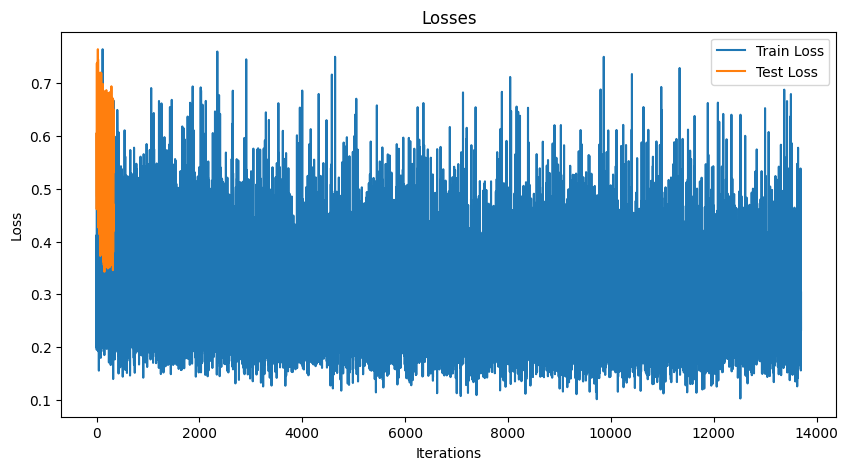

In [29]:
# plot the losses and accuracies

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Losses")
plt.plot(losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


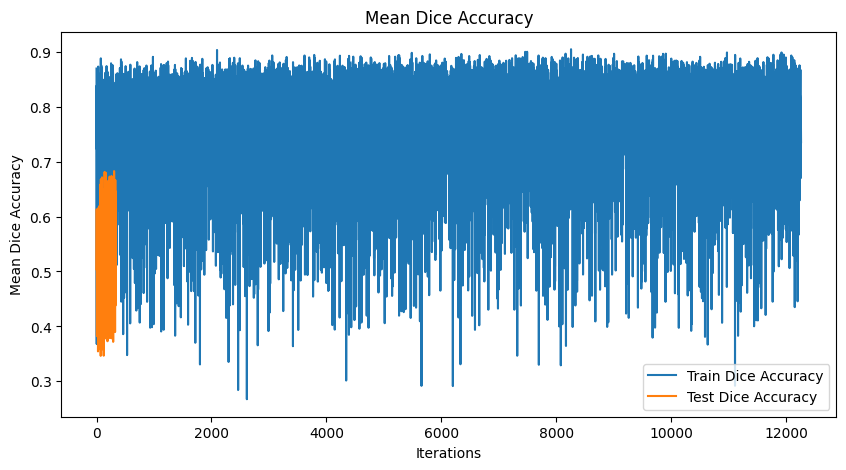

In [32]:
# plot mean dice

plt.figure(figsize=(10, 5))
plt.title("Mean Dice Accuracy")
plt.plot(np.average(dice_accs, axis=1), label="Train Dice Accuracy")
plt.plot(np.average(test_dice_accs, axis=1), label="Test Dice Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Mean Dice Accuracy")
plt.legend()
plt.show()  
